In [1]:
%matplotlib inline
from glob import glob
import os, pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
import seaborn as sns
from collections import defaultdict
base_img_dir = 'https://www.kaggle.com/code/kmader/deeplesion-csv-analysis/input?select=minideeplesion'

In [4]:
patient_df = pd.read_csv('/content/DL_info.csv')
patient_df['kaggle_path'] = patient_df.apply(lambda c_row: os.path.join(base_img_dir,
                                                                        '{Patient_index:06d}_{Study_index:02d}_{Series_ID:02d}'.format(**c_row),
                                                                        '{Key_slice_index:03d}.png'.format(**c_row)), 1)

print('Loaded', patient_df.shape[0], 'cases')
# extact the bounding boxes
patient_df['bbox'] = patient_df['Bounding_boxes'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1, 4)))
patient_df['norm_loc'] = patient_df['Normalized_lesion_location'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
patient_df['Spacing_mm_px_'] = patient_df['Spacing_mm_px_'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
patient_df['Lesion_diameters_Pixel_'] = patient_df['Lesion_diameters_Pixel_'].map(lambda x: np.reshape([float(y) for y in x.split(',')], (-1)))
patient_df['Radius_x'] = patient_df.apply(lambda x: x['Lesion_diameters_Pixel_'][0]*x['Spacing_mm_px_'][0], 1)

lesion_type_dict = dict(enumerate('Bone,Abdomen,Mediastinum,Liver,Lung,Kidney,Soft tissue,Pelvis'.split(','), 1))

patient_df['Coarse_lesion_name'] = patient_df['Coarse_lesion_type'].map(lambda x: lesion_type_dict.get(x, 'Unknown'))
for i, ax in enumerate('xyz'):
    patient_df[f'{ax}_loc'] = patient_df['norm_loc'].map(lambda x: x[i])
print('Found', patient_df.shape[0], 'patients with images')
patient_df.sample(3)

Loaded 32735 cases
Found 32735 patients with images


,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,...,Patient_age,Train_Val_Test,kaggle_path,bbox,norm_loc,Radius_x,Coarse_lesion_name,x_loc,y_loc,z_loc
3664,000327_02_02_032.png,327,2,2,32,"121.409, 281.409, 150.789, 335.008, 153.965, 3...","111.248, 276.409, 158.965, 340.008","[61.1223, 41.5663]","0.171705, 0.642548, 0.514695",5,...,74.0,3,https://www.kaggle.com/code/kmader/deeplesion-...,"[[111.248, 276.409, 158.965, 340.008]]","[0.171705, 0.642548, 0.514695]",59.689716,Lung,0.171705,0.642548,0.514695
13998,001416_01_01_015.png,1416,1,1,15,"229.548, 268.625, 242.473, 258.405, 239.768, 2...","224.548, 252.202, 247.473, 273.625","[16.4777, 13.7091]","0.466575, 0.423391, 0.439388",-1,...,11.0,1,https://www.kaggle.com/code/kmader/deeplesion-...,"[[224.548, 252.202, 247.473, 273.625]]","[0.466575, 0.423391, 0.439388]",9.654911,Unknown,0.466575,0.423391,0.439388
21433,002503_02_01_076.png,2503,2,1,76,"259.872, 219.896, 265.494, 219.896, 262.371, 2...","254.872, 211.773, 270.494, 226.77","[5.62169, 4.99706]","0.524915, 0.434918, 0.648436",-1,...,45.0,1,https://www.kaggle.com/code/kmader/deeplesion-...,"[[254.872, 211.773, 270.494, 226.77]]","[0.524915, 0.434918, 0.648436]",5.489929,Unknown,0.524915,0.434918,0.648436


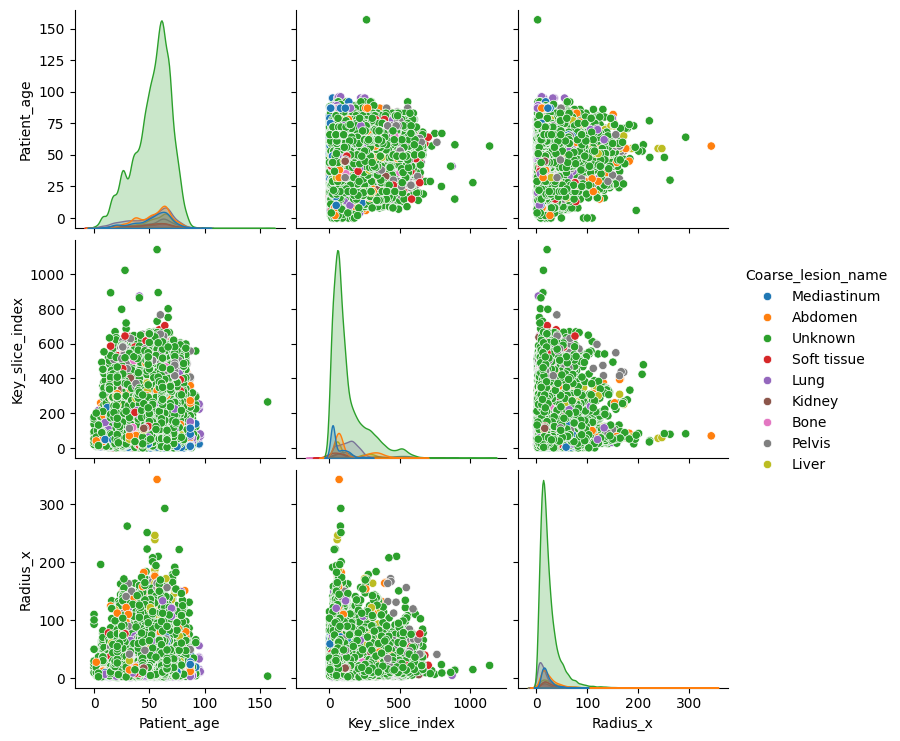

In [5]:
sns.pairplot(hue='Coarse_lesion_name', data=patient_df[['Patient_age', 'Coarse_lesion_name', 'Key_slice_index', 'Radius_x']])

,Patient_index,counts,Age_Range
3765,3787,4.0,86.0
1115,1125,12.0,51.0
494,501,19.0,34.0
1070,1080,5.0,30.0
20,24,4.0,25.0


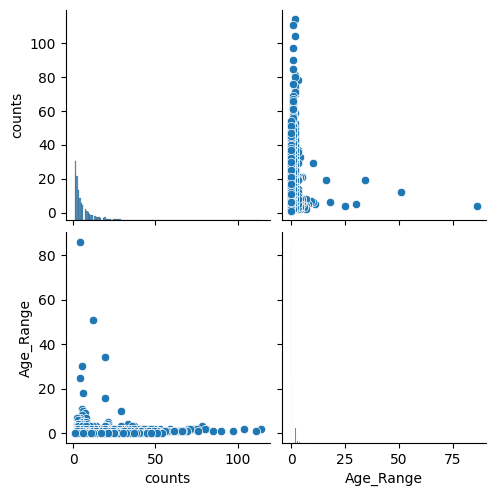

In [6]:
freq_flyers_df = patient_df.groupby('Patient_index')[['Patient_age']].apply(
    lambda x: pd.Series({'counts': x.shape[0],
                         'Age_Range': np.max(x['Patient_age'])-np.min(x['Patient_age'])})).reset_index().sort_values('Age_Range', ascending = False)
sns.pairplot(freq_flyers_df[['counts', 'Age_Range']])
freq_flyers_df.head(5)

Overall Statistics:

/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


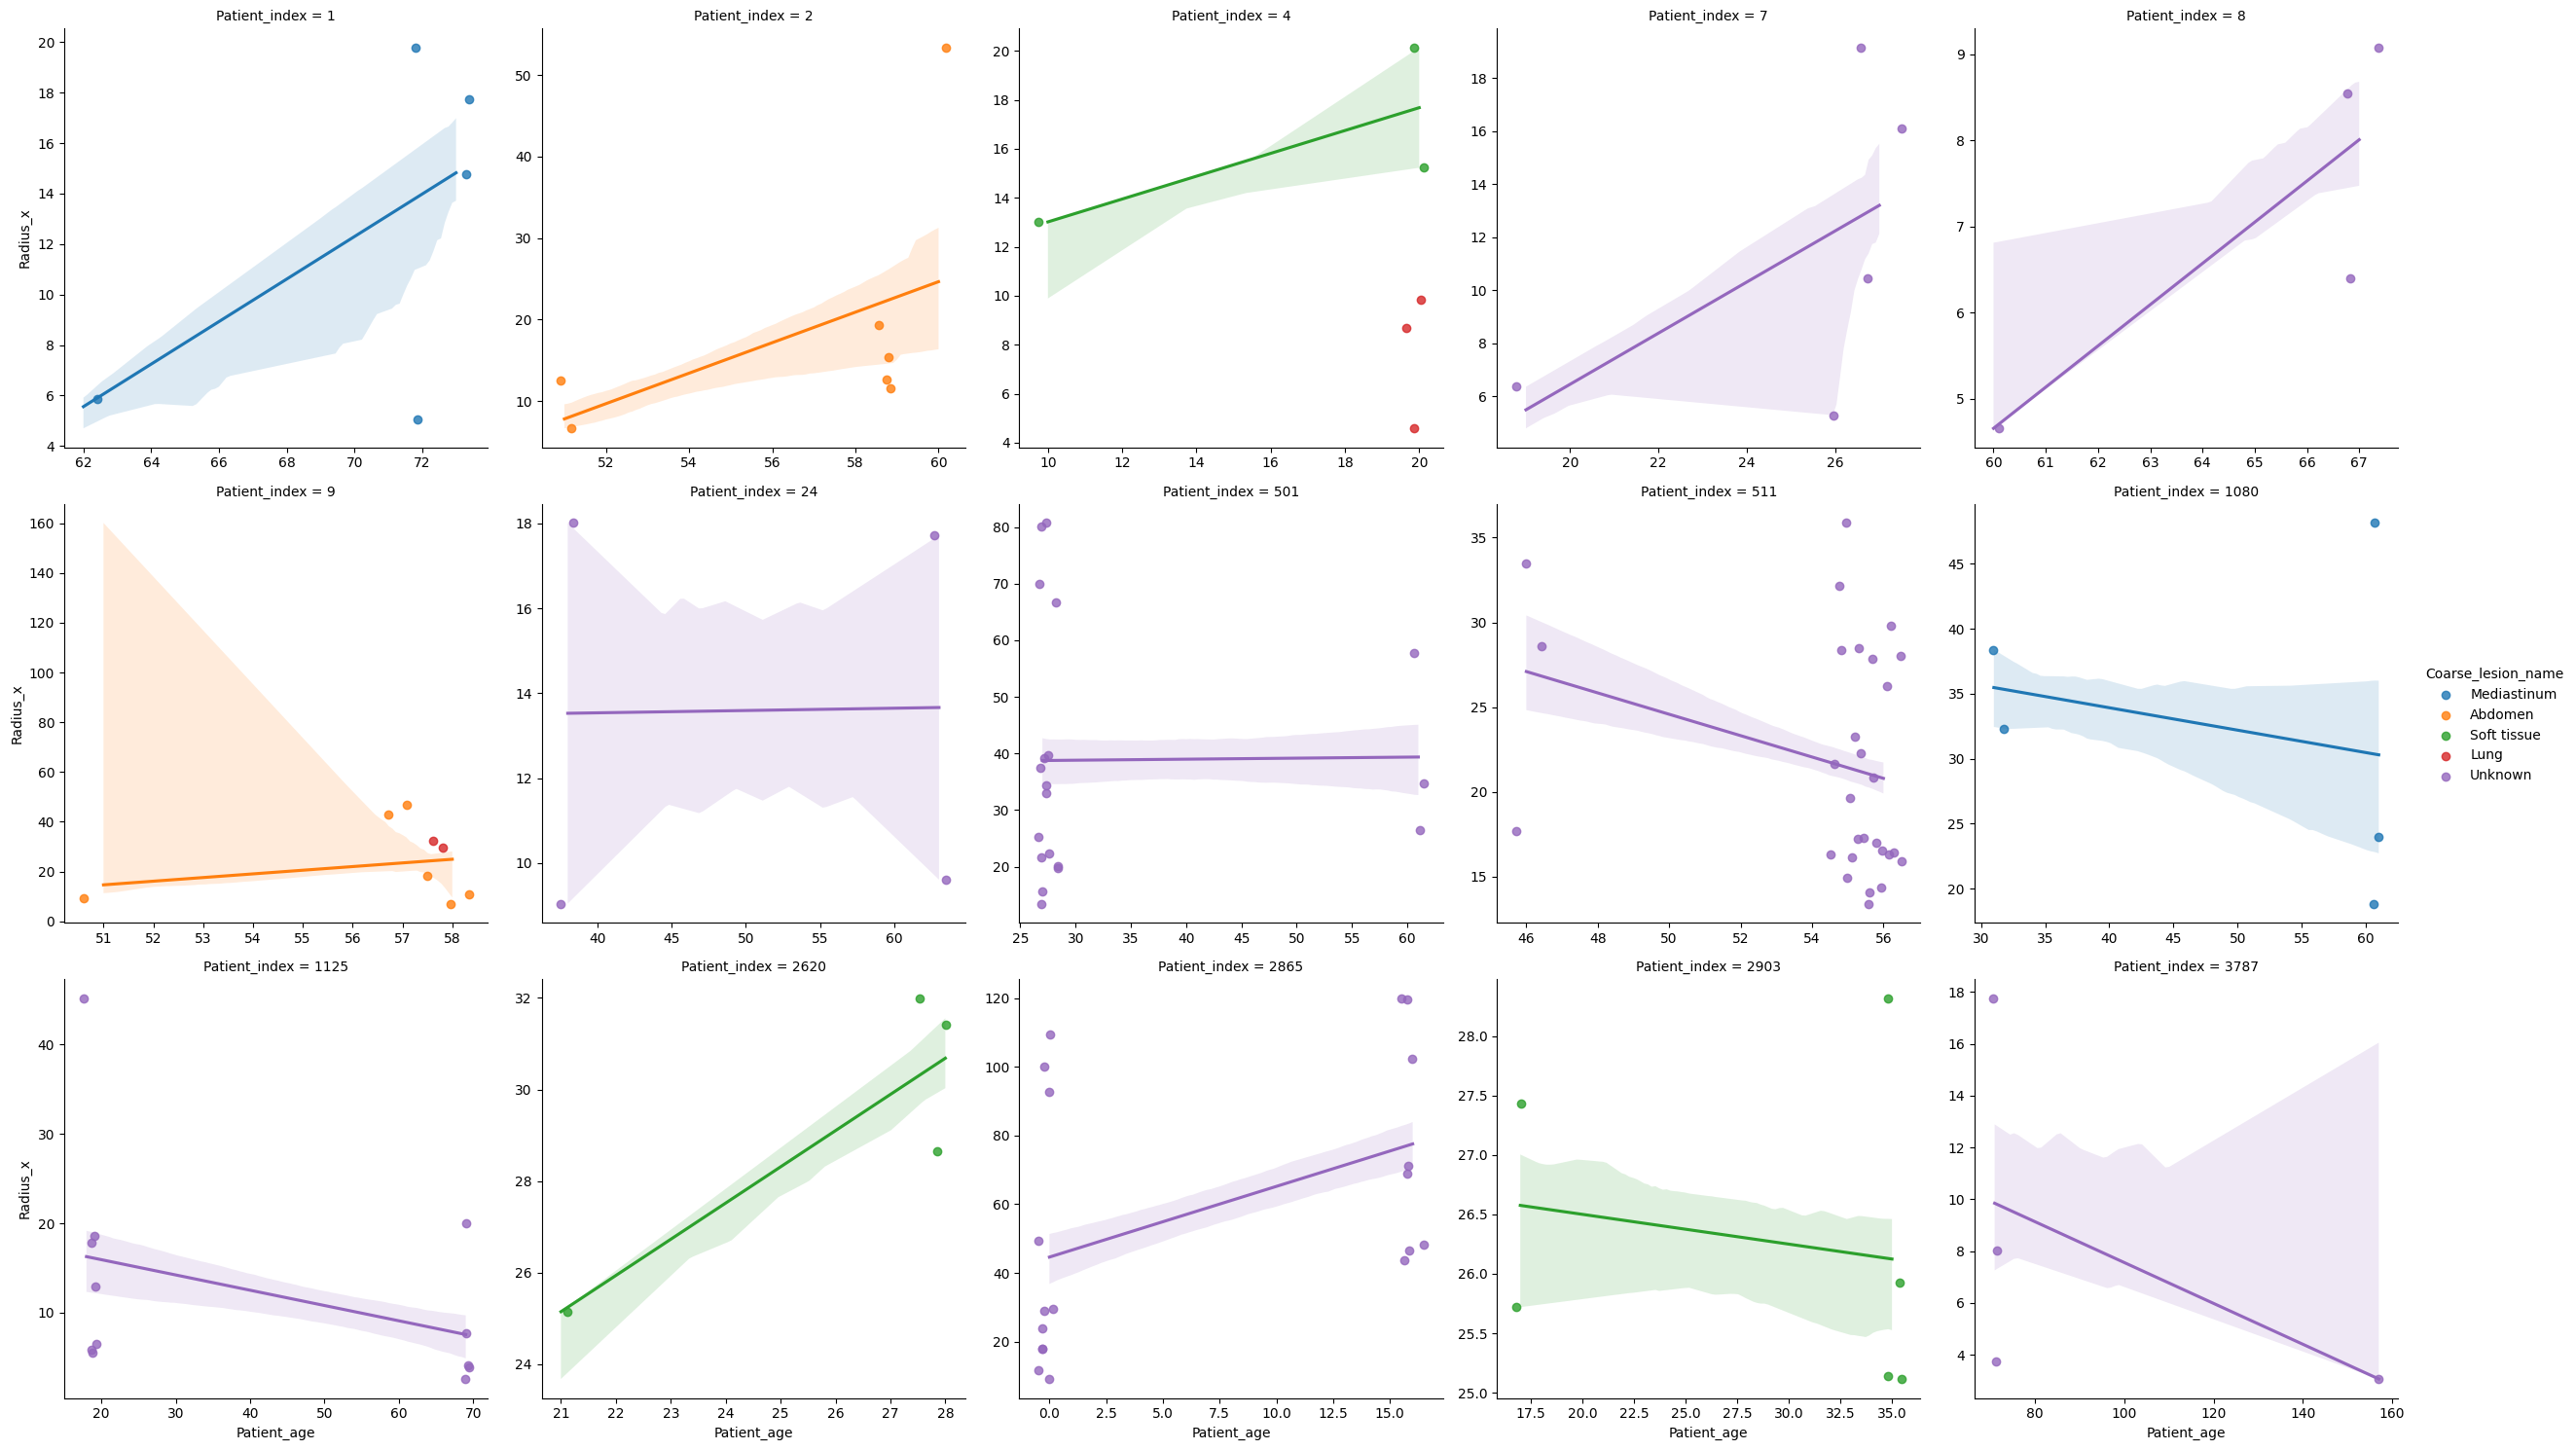

In [7]:
join_df = pd.merge(patient_df, freq_flyers_df.head(15))
ax = sns.lmplot(x='Patient_age', y='Radius_x', ci=50,
                hue = 'Coarse_lesion_name',
                sharex=False, sharey=False, x_jitter=0.5,
                 col='Patient_index', col_wrap=5,
                data = join_df)

/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


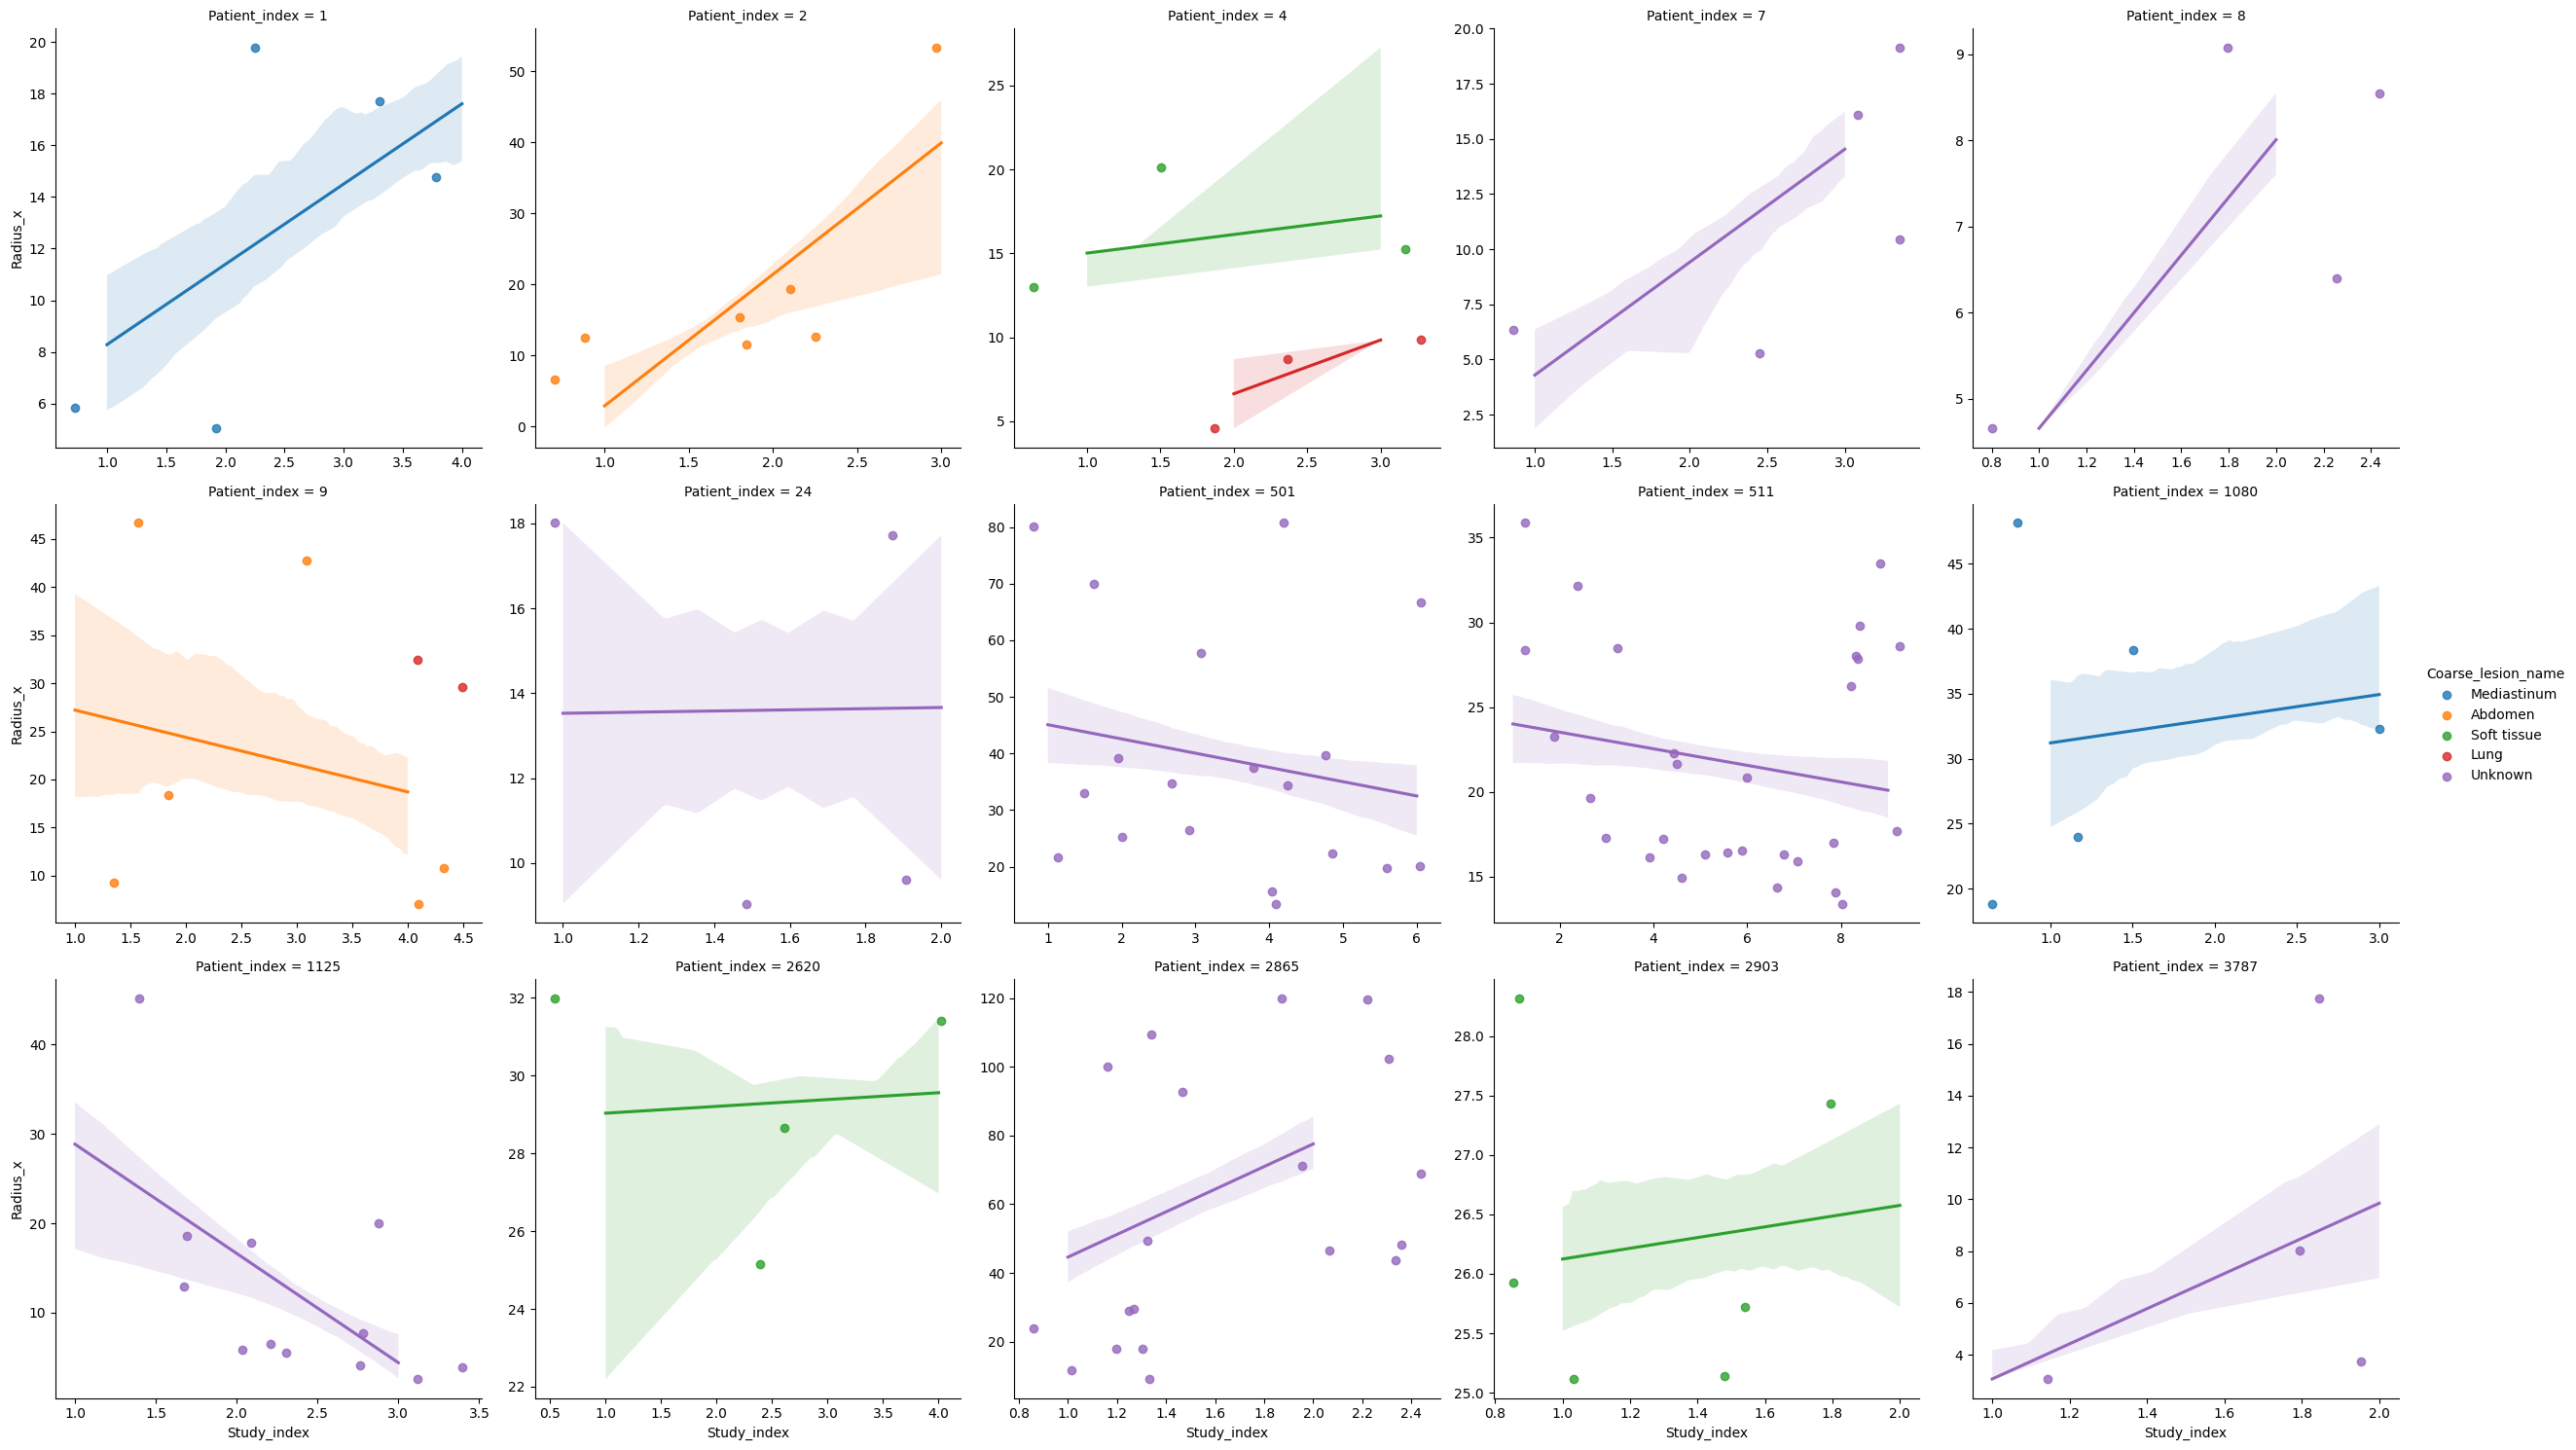

In [8]:
sns.lmplot(x='Study_index', y='Radius_x', ci=50,
                hue = 'Coarse_lesion_name',
                sharex=False, sharey=False, x_jitter=0.5,
                 col='Patient_index', col_wrap=5,
                data = join_df)

Filter Patients:

In [9]:
def count_and_check_studies(in_patient_df):
    gr_df = in_patient_df.groupby('Study_index').size().reset_index(name='counts')
    match_df = gr_df[gr_df['counts']==gr_df['counts'].max()]

    if (gr_df['counts'].max()>1) and (match_df.shape[0]>1): # more than one study and more than one series
        return in_patient_df[in_patient_df['Study_index'].isin(match_df['Study_index'])]
    else:
        return in_patient_df.head(0)
grp_patient_df = patient_df.groupby(['Patient_index']).apply(count_and_check_studies).reset_index(drop = True)
print(grp_patient_df.shape[0], 'scans available')
print(len(grp_patient_df['Patient_index'].value_counts()), 'patients')
print(len(grp_patient_df.groupby(['Patient_index', 'Study_index'])), 'studies')
grp_patient_df.head(5)

3313 scans available
419 patients
962 studies


,File_name,Patient_index,Study_index,Series_ID,Key_slice_index,Measurement_coordinates,Bounding_boxes,Lesion_diameters_Pixel_,Normalized_lesion_location,Coarse_lesion_type,...,Patient_age,Train_Val_Test,kaggle_path,bbox,norm_loc,Radius_x,Coarse_lesion_name,x_loc,y_loc,z_loc
0,000016_01_01_008.png,16,1,1,8,"262.222, 214.222, 286.222, 214.222, 274.667, 2...","257.222, 200.333, 291.222, 231.667","[24.0, 21.3518]","0.541926, 0.350768, 0.578449",4,...,54.0,3,https://www.kaggle.com/code/kmader/deeplesion-...,"[[257.222, 200.333, 291.222, 231.667]]","[0.541926, 0.350768, 0.578449]",16.875000,Liver,0.541926,0.350768,0.578449
1,000016_01_01_030.png,16,1,1,30,"360, 359.111, 331.556, 345.778, 350.222, 344, ...","326.556, 339, 365, 364.111","[31.4144, 15.5238]","0.682724, 0.63216, 0.687355",6,...,54.0,3,https://www.kaggle.com/code/kmader/deeplesion-...,"[[326.556, 339.0, 365.0, 364.111]]","[0.682724, 0.63216, 0.687355]",22.088250,Kidney,0.682724,0.632160,0.687355
2,000016_01_01_030.png,16,1,1,30,"146.667, 307.556, 104.889, 339.556, 131.556, 3...","99.8889, 302.556, 151.667, 355.222","[52.6249, 48.9535]","0.221222, 0.586175, 0.687355",6,...,54.0,3,https://www.kaggle.com/code/kmader/deeplesion-...,"[[99.8889, 302.556, 151.667, 355.222]]","[0.221222, 0.586175, 0.687355]",37.001883,Kidney,0.221222,0.586175,0.687355
3,000016_01_01_025.png,16,1,1,25,"172.444, 358.222, 125.333, 340.444, 144.889, 3...","120.333, 331, 177.444, 370.333","[50.3538, 31.5274]","0.254966, 0.628073, 0.670661",6,...,54.0,3,https://www.kaggle.com/code/kmader/deeplesion-...,"[[120.333, 331.0, 177.444, 370.333]]","[0.254966, 0.628073, 0.670661]",35.405016,Kidney,0.254966,0.628073,0.670661
4,000016_02_01_253.png,16,2,1,253,"263.656, 204.963, 284.07, 204.113, 273.012, 21...","258.656, 190.607, 289.07, 218.469","[20.4324, 17.8831]","0.524361, 0.344255, 0.579124",4,...,59.0,3,https://www.kaggle.com/code/kmader/deeplesion-...,"[[258.656, 190.607, 289.07, 218.469]]","[0.524361, 0.344255, 0.579124]",16.754568,Liver,0.524361,0.344255,0.579124


/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:598: UserWarning: sharex is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/regression.py:598: UserWarning: sharey is deprecated from the `lmplot` function signature. Please update your code to pass it using `facet_kws`.
  warnings.warn(msg, UserWarning)


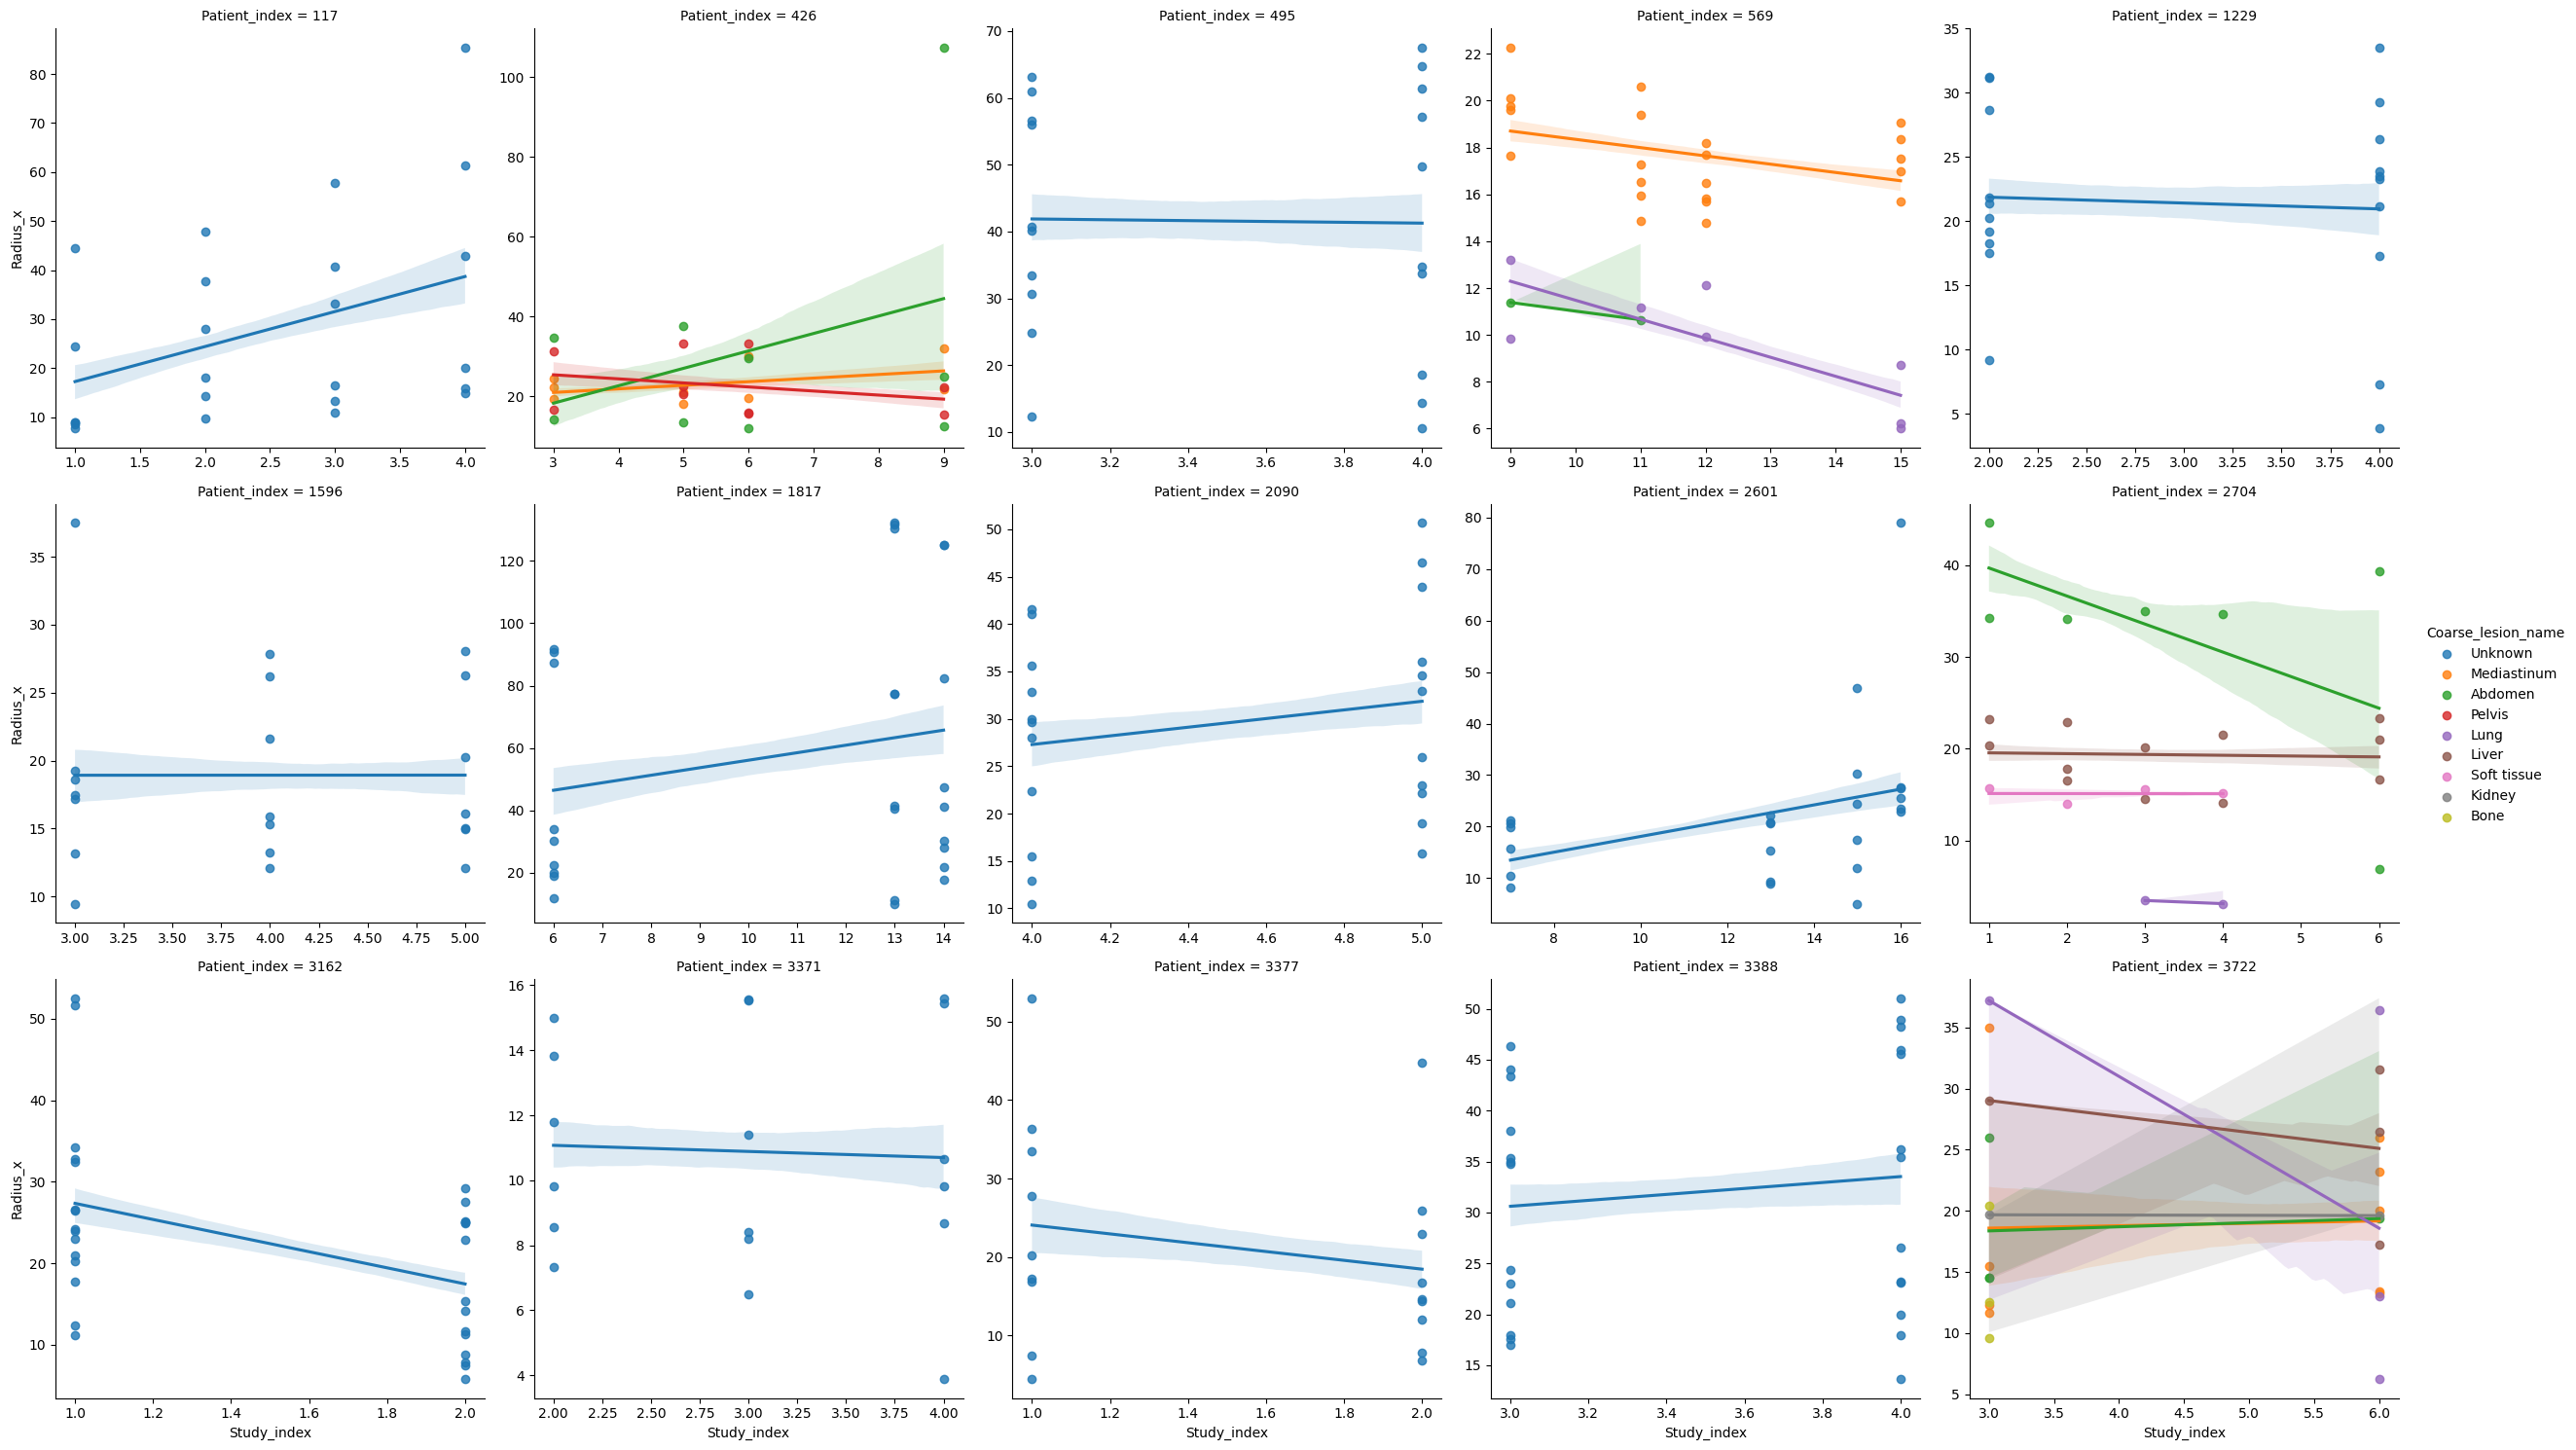

In [10]:
ff_grp_df = grp_patient_df.groupby(['Patient_index']).size().reset_index(name='counts').sort_values('counts', ascending=False)
join_df = pd.merge(grp_patient_df, ff_grp_df.head(15))
sns.lmplot(x='Study_index', y='Radius_x', ci=50,
                hue = 'Coarse_lesion_name',
                sharex=False, sharey=False,
                 col='Patient_index', col_wrap=5,
                data = join_df)

In [16]:
# Check for missing values in the data
missing_values = patient_df.isnull().sum()

# If missing values are present, handle them using an imputer transformer
if missing_values.any():
    from sklearn.impute import SimpleImputer

    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    X = imputer.fit_transform(X)

# Otherwise, drop rows with missing values
else:
    X = X.dropna()

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the model
model = LogisticRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.693600122193371
Precision: 0.4810811295066592
Recall: 0.693600122193371
F1 Score: 0.568116550303048


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Assuming 'model' is the trained LogisticRegression model
while True:
    try:
        patient_index = int(input("Enter Patient Index: "))
        study_index = int(input("Enter Study Index: "))
        series_id = int(input("Enter Series ID: "))
        key_slice_index = int(input("Enter Key Slice Index: "))
        patient_age = float(input("Enter Patient Age: "))

        # Create a DataFrame with the input data
        input_data = pd.DataFrame([[patient_index, study_index, series_id, key_slice_index, patient_age]],
                                   columns=['Patient_index', 'Study_index', 'Series_ID', 'Key_slice_index', 'Patient_age'])

        # Make prediction
        prediction = model.predict(input_data)[0]
        print("Prediction:", prediction)

    except ValueError:
        print("Please enter valid numeric values.")

    cont = input("Do you want to continue (y/n)? ")
    if cont.lower() != 'y':
        break


Enter Patient Index: 327
Enter Study Index: 2
Enter Series ID: 2
Enter Key Slice Index: 32
Enter Patient Age: 74.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Prediction: 1
Do you want to continue (y/n)? y
Enter Patient Index: 1416
Enter Study Index: 1
Enter Series ID: 1
Enter Key Slice Index: 15
Enter Patient Age: 11.0


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Prediction: 1
Do you want to continue (y/n)? n
